In [2]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import warnings
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

warnings.filterwarnings('ignore')

# Run the final model

In [3]:
df = pd.read_csv('ds_challenge_data_final.csv',sep='\t')
df.fillna(0, inplace = True)

In [4]:
pred_cat_cols = ['holiday_nm']
cols_to_drop = ['Transaction_Date','Hash_Trans_ID','PRO' ]

In [5]:
df['holiday_nm'] = df['holiday_nm'].apply(lambda x: 'none' if ((str(x).strip()=='0') | (x==0)) else x)

In [6]:
df = pd.get_dummies(data=df, columns = pred_cat_cols)

In [7]:
df_train = df[df['Transaction_Year'] < 2015]
train_targets = df_train['PRO'].as_matrix().astype('float32')
train_data = df_train.drop(cols_to_drop, axis=1, inplace=False).as_matrix().astype('float32')
df_test = df[df['Transaction_Year'] == 2015]
test_targets = df_test['PRO'].as_matrix().astype('float32')
test_data = df_test.drop(cols_to_drop, axis=1, inplace=False).as_matrix().astype('float32')

In [8]:
mdl = xgb.XGBClassifier(max_depth=2, min_child_weight=1, reg_alpha=1e-5, gamma=0,subsample=0.9, colsample_bytree=0.75, learning_rate=0.2, n_estimators=250, verbosity=1, n_jobs=-1)

In [9]:
mdl.fit(train_data,train_targets)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.75, gamma=0, learning_rate=0.2,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
              n_estimators=250, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=1e-05,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.9, verbosity=1)

In [10]:
test_pred = mdl.predict_proba(test_data)
predictions = np.array(test_pred)[:,1]
actuals = test_targets.astype('int')
fpr, tpr, thresholds = metrics.roc_curve(actuals, predictions, pos_label=1)
metrics.auc(fpr, tpr)

0.7188943450700578

# Confusion Matrix Plot

In [11]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Choose the probability threshold

As can be seen by reducing threshold more PRO customers will be identified with cost of huge false positives, and by increasing it less PRO customers will be identified with the cost of huge true negatives. 0.5 value seems to be the most balanced number to be used in this case.


Confusion matrix, without normalization
[[18350 12144]
 [ 7017 17982]]


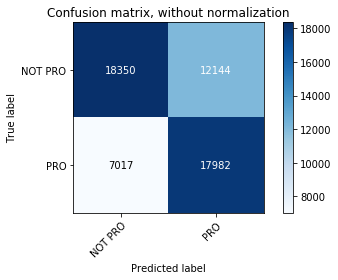

In [12]:
thres = 0.5
def f(x):
    return 1 if x>=thres else 0
y_pred = np.array(list(map(f, predictions)))
plot_confusion_matrix(actuals, y_pred, np.array(['NOT PRO','PRO']))

Confusion matrix, without normalization
[[30104   390]
 [22771  2228]]


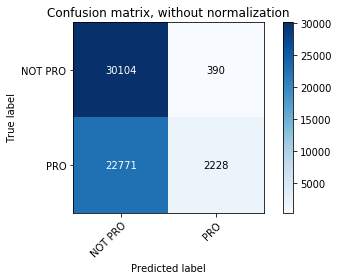

In [13]:
thres = 0.8
def f(x):
    return 1 if x>=thres else 0
y_pred = np.array(list(map(f, predictions)))
plot_confusion_matrix(actuals, y_pred, np.array(['NOT PRO','PRO']))

Confusion matrix, without normalization
[[  337 30157]
 [   84 24915]]


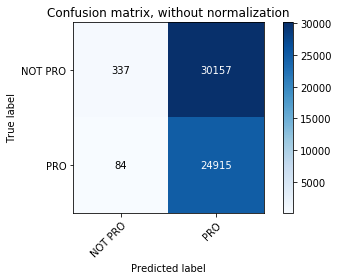

In [14]:
thres = 0.2
def f(x):
    return 1 if x>=thres else 0
y_pred = np.array(list(map(f, predictions)))
plot_confusion_matrix(actuals, y_pred, np.array(['NOT PRO','PRO']))